Paquetes necesarios

In [1]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

TAREA: Realiza la cuenta de píxeles blancos por filas (en lugar de por columnas). Determina el valor máximo de píxeles blancos para filas, maxfil, mostrando el número de filas y sus respectivas posiciones, con un número de píxeles blancos mayor o igual que 0.90*maxfil.

Máximo de píxeles blancos en una fila: 0.4296875
Número de filas con ≥ 0.9*maxfil: 7
Posiciones de estas filas: [  6  12  15  20  21  88 100]


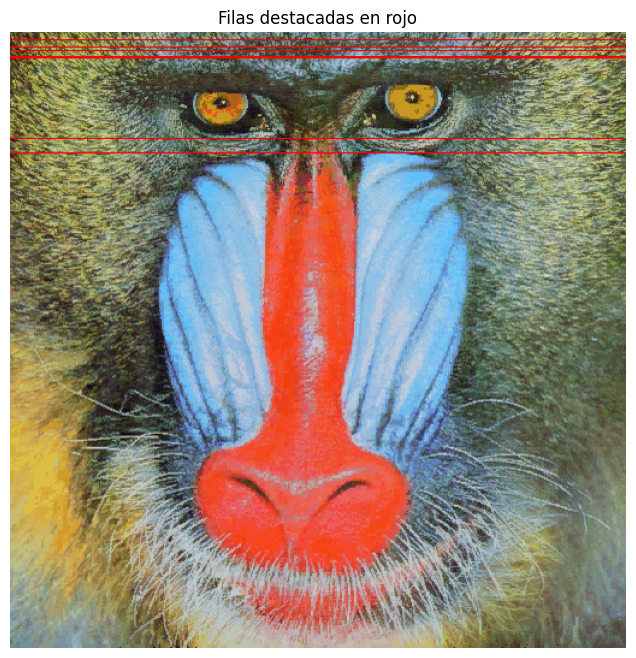

In [3]:
# Leer imagen y convertir a gris
img = cv2.imread('mandril.jpg')
if img is None:
    raise FileNotFoundError("Imagen 'mandril.jpg' no encontrada")

gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Aplicar Canny para obtener bordes
canny = cv2.Canny(gris, 100, 200)

# Contar píxeles blancos por fila
row_counts = cv2.reduce(canny, 1, cv2.REDUCE_SUM, dtype=cv2.CV_32SC1)
filas = row_counts[:,0] / (255 * canny.shape[1])  # Normalizar al número de columnas

# Valor máximo de píxeles blancos por fila
maxfil = np.max(filas)
print(f"Máximo de píxeles blancos en una fila: {maxfil}")

# Filas con píxeles ≥ 0.9 * maxfil
filas_destacadas = np.where(filas >= 0.9*maxfil)[0]
print(f"Número de filas con ≥ 0.9*maxfil: {len(filas_destacadas)}")
print(f"Posiciones de estas filas: {filas_destacadas}")

# Visualización: marcar filas destacadas sobre la imagen original
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_marcada = img_rgb.copy()

for f in filas_destacadas:
    cv2.line(img_marcada, (0, f), (img_marcada.shape[1]-1, f), (255,0,0), 1)

plt.figure(figsize=(10,8))
plt.axis("off")
plt.title("Filas destacadas en rojo")
plt.imshow(img_marcada)
plt.show()

TAREA: Aplica umbralizado a la imagen resultante de Sobel (convertida a 8 bits), y posteriormente realiza el conteo por filas y columnas similar al realizado en el ejemplo con la salida de Canny de píxeles no nulos. Calcula el valor máximo de la cuenta por filas y columnas, y determina las filas y columnas por encima del 0.90*máximo. Remarca con alguna primitiva gráfica dichas filas y columnas sobre la imagen del mandril. ¿Cómo se comparan los resultados obtenidos a partir de Sobel y Canny?

Máximo de píxeles blancos en una fila (Sobel): 398
Máximo de píxeles blancos en una columna (Sobel): 347


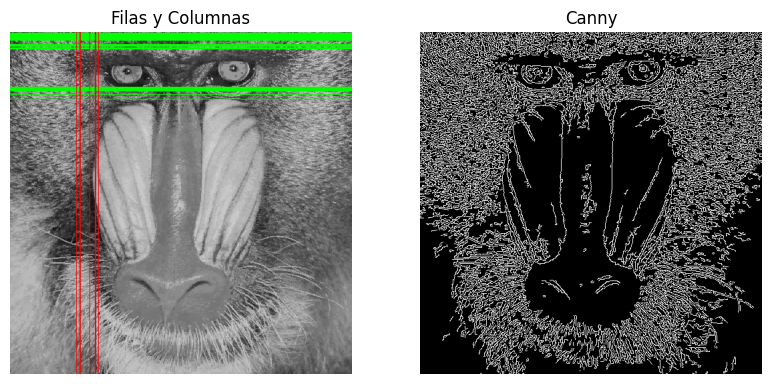

In [4]:

img = cv2.imread("mandril.jpg", cv2.IMREAD_GRAYSCALE)

# Aplicamos el filtro Sobel en x e y
sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)

# Magnitud del gradiente
sobel_mag = np.sqrt(sobelx**2 + sobely**2)

# a 8 Bits
sobel_8u = cv2.convertScaleAbs(sobel_mag)


# Todo píxel > 100 será blanco, el resto negro
_, sobel_thresh = cv2.threshold(sobel_8u, 100, 255, cv2.THRESH_BINARY)


# Contamos píxeles blancos por filas y columnas
row_counts = np.count_nonzero(sobel_thresh, axis=1)
col_counts = np.count_nonzero(sobel_thresh, axis=0)


row_max = np.max(row_counts)
col_max = np.max(col_counts)


row_thr = 0.90 * row_max
col_thr = 0.90 * col_max

# Identificamos filas y columnas 
rows_selected = np.where(row_counts >= row_thr)[0]
cols_selected = np.where(col_counts >= col_thr)[0] 


img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

# Filas
for r in rows_selected:
    cv2.line(img_color, (0, r), (img.shape[1], r), (0, 255, 0), 1) #Verde en rgb

# Columnas
for c in cols_selected:
    cv2.line(img_color, (c, 0), (c, img.shape[0]), (0, 0, 255), 1) #Rojo en rgb

print(f"Máximo de píxeles blancos en una fila (Sobel): {row_max}")
print(f"Máximo de píxeles blancos en una columna (Sobel): {col_max}")

plt.figure(figsize=(15,5))  

plt.subplot(1,3,2)
plt.title("Filas y Columnas")
plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Canny")
edges_canny = cv2.Canny(img, 100, 200)
plt.imshow(edges_canny, cmap="gray")
plt.axis("off")

plt.show()


TAREA: Proponer un demostrador que capture las imágenes de la cámara, y les permita exhibir lo aprendido en estas dos prácticas ante quienes no cursen la asignatura :). Es por ello que además de poder mostrar la imagen original de la webcam, permita cambiar de modo, incluyendo al menos dos procesamientos diferentes como resultado de aplicar las funciones de OpenCV trabajadas hasta ahora.


In [ ]:
# Inicializa la cámara
vid = cv2.VideoCapture(0)
if not vid.isOpened():
    print("Error: cámara no encontrada")
    exit()

mode = 1

# LUT para visión térmica (Predator)
thermal_lut = np.zeros((256,1,3), dtype=np.uint8)

for i in range(256):
    if i < 64:        # negro -> azul
        thermal_lut[i,0] = [i*4, 0, 0]              # el canal azul aumenta gradualmente
    elif i < 128:     # azul -> cian
        thermal_lut[i,0] = [255, (i-64)*4, 0]       # azul al máximo, verde va creciendo
    elif i < 160:     # cian -> verde
        thermal_lut[i,0] = [255-(i-128)*8, 255, 0]  # azul disminuye, verde al máximo
    elif i < 192:     # verde -> amarillo
        thermal_lut[i,0] = [0, 255, (i-160)*8]      # se añade rojo, verde se mantiene
    elif i < 224:     # amarillo -> rojo
        thermal_lut[i,0] = [0, 255-(i-192)*8, 255]  # verde disminuye, rojo al máximo
    else:             # rojo -> blanco
        val = min((i-224)*11, 255)
        thermal_lut[i,0] = [val, val, 255]          # se añaden azul y verde hasta llegar a blanco


while True:
    ret, frame = vid.read()
    if not ret:
        break

    if mode == 1:
        # Modo normal
        out = frame.copy()

    elif mode == 2:
        # Filtro Robocop
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Calcula bordes con Sobel (futurista)
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        mag = cv2.magnitude(sobelx, sobely)
        edges = cv2.convertScaleAbs(mag)
        
        # Encuentra el punto más brillante
        minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(gray)
        target_x, target_y = maxLoc
        
        # Imagen en blanco y negro para efecto Robocop
        out = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
        
        # Dibuja el cuadrado verde alrededor del target
        rect_size = 50
        top_left = (target_x-rect_size//2, target_y-rect_size//2)
        bottom_right = (target_x+rect_size//2, target_y+rect_size//2)
        cv2.rectangle(out, top_left, bottom_right, (0,255,0), 2)
        
        # Dibuja la cruz verde completa
        cv2.line(out, (target_x, 0), (target_x, frame.shape[0]), (0,255,0), 1)
        cv2.line(out, (0, target_y), (frame.shape[1], target_y), (0,255,0), 1)
        
        # Marca el centro con un círculo pequeño
        cv2.circle(out, (target_x, target_y), 5, (0,255,0), -1)

    elif mode == 3:
    # Filtro Predator (visión térmica)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Convertimos gray a BGR para aplicar la LUT manual
        gray_bgr = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    
    # Aplica la LUT canal por canal
        out = cv2.LUT(gray_bgr, thermal_lut)

    # Texto indicativo de la modalidad
    cv2.putText(out, f"Modo {mode}  (1=Normal 2=Robocop 3=Predator)  q/ESC salir",
                (10,25), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0),2,cv2.LINE_AA)

    # Muestra la imagen
    cv2.imshow("Webcam Filtrada", out)

    key = cv2.waitKey(20) & 0xFF
    if key == 27 or key == ord('q'):
        break
    elif key == ord('1'):
        mode = 1
    elif key == ord('2'):
        mode = 2
    elif key == ord('3'):
        mode = 3

vid.release()
cv2.destroyAllWindows()

TAREA: Tras ver los vídeos [My little piece of privacy](https://www.niklasroy.com/project/88/my-little-piece-of-privacy), [Messa di voce](https://youtu.be/GfoqiyB1ndE?feature=shared) y [Virtual air guitar](https://youtu.be/FIAmyoEpV5c?feature=shared) proponer un demostrador reinterpretando la parte de procesamiento de la imagen, tomando como punto de partida alguna de dichas instalaciones.

In [ ]:
# Abrimos la cámara web
cap = cv2.VideoCapture(0)

# Leemos el primer frame y lo convertimos a gris
ret, frame = cap.read()
prev_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# Bucle principal
while True:
    # Leemos un frame de la cámara
    ret, frame = cap.read()
    if not ret:
        break

    # Espejamos la imagen para que sea como un espejo
    frame = cv2.flip(frame, 1)

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Calculamos la diferencia entre el frame actual y el anterior
    diff = cv2.absdiff(prev_gray, gray)

    # Aplicamos un umbral
    _, thresh = cv2.threshold(diff, 25, 255, cv2.THRESH_BINARY)

    # Contornos del movimiento
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # Tomamos el contorno más grande
        c = max(contours, key=cv2.contourArea)
        if cv2.contourArea(c) > 5000:  # Solo movimientos grandes
            x, y, w, h = cv2.boundingRect(c)
            cx = x + w // 2  # Centro horizontal del contorno

            # “Tenda" vertical que sigue
            cv2.rectangle(frame, (cx-20, 0), (cx+20, frame.shape[0]), (0,0,255), -1)

            # Escribimos un texto en la pantalla
            cv2.putText(frame, "Tenda", (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)

    # Guardamos el frame actual como anterior para el próximo ciclo
    prev_gray = gray

    # Mostramos la imagen final
    cv2.imshow("Demo Tenda", frame)

    # Salimos si presionamos la tecla ESC
    if cv2.waitKey(1) & 0xFF == 27:
        break

# Liberamos la cámara y cerramos las ventanas
cap.release()
cv2.destroyAllWindows()